A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


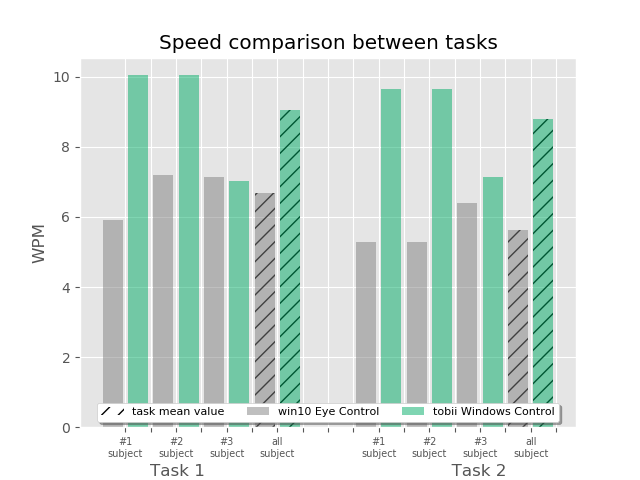

In [5]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np
import seaborn as sns


# create Sentence class
class Sentence:
	# class variable shared by all instances
	def __init__(self, subject, task, sentenceNo, testing):
		# instance variable unique to each instance
		self.subject = subject
		self.task = task			# 0: transcribe; 1: free conversation
		self.sentenceNo = sentenceNo
		self.testing = testing
		self.P = ""
		self.T = ""
		self.IS = ""
		self.wpm = 0.0
		self.totErrRate = 0.0
		self.keyboard = 0	# 0: win10 Eye Control; 1: tobii Win Control

def readSentences(argFilename, argSentences):
	with open('RawData/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			# write on keyboard clasification
			if 'Transcribe' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 0, int(row[0]), int(row[1])))
			elif 'FreeConv' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 1, int(row[0]), int(row[1])))
			# else:
				# print('error in csv file naming!')
			# exclude exceptions that the test subject didn't enter anything and skipped this sentence
			if int(row[2]) != 0:
				sentences[-1].wpm = int(row[4])+int(row[5])*0.1**(len(row[5]))
				# print(sentences[-1].wpm)
				sentences[-1].totErrRate = int(row[-14])*0.1**(len(row[-14]))
			else:
				sentences[-1].wpm = 0
				sentences[-1].totErrRate = 1
			if 'winEyeControl' in argFilename:
				sentences[-1].keyboard = 0
			elif 'tobiiWinControl' in argFilename:
				sentences[-1].keyboard = 1
			# print(argSentences[-1].sentenceNo)
			# print(len(row))

def onChange_plotType(b):
	if b['type'] == 'change' and b['name'] == 'value':
		clear_output(wait=True)
		display(contrPlotType, widgets.HBox([contrTask, contrSubject, contrKeybd]))
		if contrPlotType.value == 'Speed over sentences':
			# plots()
			plotSpeedOverSentences()
			contrTask.disabled = False
			contrSubject.disabled = False
			contrKeybd.disabled = True
		elif contrPlotType.value == 'Speed between tasks':
			plotWpmBetweenTasks()
			contrTask.disabled = True
			contrSubject.disabled = True
			contrKeybd.disabled = True
		elif contrPlotType.value == 'Irrelavant variables influence':
			plotInfTaskSubject()
			contrTask.disabled = True
			contrSubject.disabled = True
			contrKeybd.disabled = False

def onChange_params(change):
	if change['type'] == 'change' and change['name'] == 'value':
		onChange_plotType(change)	

# def delOutliers(argSentenceSet):
# 	print('did not filter')

def plotSpeedOverSentences():
	wpmOfASubject, errRateOfASubject = ([[] for i in range(amountKeybd)] for j in range(2))
	wpmMeanOfASubject = [0, 0]
	wpmOfSubjects, errRateSubjects = ([[[], [], []], [[], [], []]] for i in range(2))
	wpmMeanSubjects = [[], []]
	for item in sentences:
		if item.testing == 1:
			try:
				if item.subject == int(contrSubject.value[1])-1:
					if (contrTask.value == 'Transcribe' and item.task == 0) or (contrTask.value == 'Free Conversation' and item.task == 1):
						wpmOfASubject[item.keyboard].append(item.wpm)
						errRateOfASubject[item.keyboard].append(item.totErrRate)
			except ValueError:
				if (contrTask.value == 'Transcribe' and item.task == 0) or (contrTask.value == 'Free Conversation' and item.task == 1):
					wpmOfSubjects[item.keyboard][item.subject].append(item.wpm)
					errRateSubjects[item.keyboard][item.subject].append(item.totErrRate)
	fig, ax = plt.subplots()
	color = ['gray', dynavoxGreen]
	label = ['win10 Eye Control', 'tobii Win Control']
	labelMean = ['win10 Eye Control mean', 'tobii Win Control mean']
	try:
		if int(contrSubject.value[1]) in [1,2,3]:
			# plot wpm for a subject over sentences & wpm mean value within a task of a subject			
			for i in range(amountKeybd):
				wpmMeanOfASubject[i] = np.mean(wpmOfASubject[i])
				plt.scatter([j for j in range(len(wpmOfASubject[i]))], wpmOfASubject[i], c=errRateOfASubject[i])
				plt.plot([j for j in range(len(wpmOfASubject[i]))], wpmOfASubject[i], 'o-', color=color[i], alpha=0.3, label=label[i])
				plt.plot([0, len(wpmOfASubject[i])], [wpmMeanOfASubject[i],wpmMeanOfASubject[i]], '--', color=color[i], label=labelMean[i])
	except ValueError:
		# plot wpm mean value across subject over sentences
		for i in range(amountKeybd):
			for j in range(amountSubject):
				plt.scatter([k for k in range(len(wpmOfSubjects[i][j]))], wpmOfSubjects[i][j], c=errRateSubjects[i][j])
				plt.scatter([k for k in range(len(wpmOfSubjects[i][j]))], wpmOfSubjects[i][j], color=color[i], alpha=0.3, label=label[i])

		wpmMeanBuffer = [[], []]
		for i in range(amountKeybd):
			for k in range(13):
				try:
					for j in range(amountSubject):			
						wpmMeanBuffer[i].append(wpmOfSubjects[i][j][k])
					wpmMeanSubjects[i].append(np.mean(wpmMeanBuffer[i]))
				except IndexError:
					pass
			plt.plot([h for h in range(len(wpmMeanSubjects[i]))], wpmMeanSubjects[i], color=color[i], alpha=0.5, label=labelMean[i])

	plt.set_cmap('gray')	# high error rate deepen the scatter color
	ax.set(title='Speed over sentences', xlabel='Sentence', ylabel='WPM')
	ax.legend(loc='lower center', ncol=2)

def plotWpmBetweenTasks():
	# sentenceTask1=[[sentences for task0],[sentences for task1]]
	sentenceTask0, sentenceTask1 = ([] for i in range(2))
	# 3 subjects, so tempSentenceTask0 = [[]*3]
	tempSentenceTask0Keybd0, tempSentenceTask0Keybd1, tempSentenceTask1Keybd0, tempSentenceTask1Keybd1 = ([[], [], []] for i in range(4))
	tempWpmTask0Keybd0, tempWpmTask0Keybd1, tempWpmTask1Keybd0, tempWpmTask1Keybd1 = ([[], [], []] for i in range(4))
	for item in sentences:
		if item.task == 0:
			if item.keyboard == 0:
				tempWpmTask0Keybd0[item.subject].append(item.wpm)
			elif item.keyboard == 1:
				tempWpmTask0Keybd1[item.subject].append(item.wpm)
		elif item.task == 1:
			if item.keyboard == 0:
				tempWpmTask1Keybd0[item.subject].append(item.wpm)
			elif item.keyboard == 1:
				tempWpmTask1Keybd1[item.subject].append(item.wpm)
	# calculate mean values
	# wpmMeanTaskN = [[0]*m]*n, m = subject # + 1, n = keyboard #
	wpmMeanTask0, wpmMeanTask1 = ([[], []] for i in range(2))
	wpmMeanTask0[0] = [np.mean(tempWpmTask0Keybd0[0]), np.mean(tempWpmTask0Keybd0[1]), np.mean(tempWpmTask0Keybd0[2]), 
					np.mean(tempWpmTask0Keybd0[0]+tempWpmTask0Keybd0[1]+tempWpmTask0Keybd0[2])]
	wpmMeanTask0[1] = [np.mean(tempWpmTask0Keybd1[1]), np.mean(tempWpmTask0Keybd1[1]), np.mean(tempWpmTask0Keybd1[2]), 
					np.mean(tempWpmTask0Keybd1[1]+tempWpmTask0Keybd1[1]+tempWpmTask0Keybd1[2])]
	wpmMeanTask1[0] = [np.mean(tempWpmTask1Keybd0[1]), np.mean(tempWpmTask1Keybd0[1]), np.mean(tempWpmTask1Keybd0[2]), 
					np.mean(tempWpmTask1Keybd0[1]+tempWpmTask1Keybd0[1]+tempWpmTask1Keybd0[2])]
	wpmMeanTask1[1] = [np.mean(tempWpmTask1Keybd1[1]), np.mean(tempWpmTask1Keybd1[1]), np.mean(tempWpmTask1Keybd1[2]), 
					np.mean(tempWpmTask1Keybd1[1]+tempWpmTask1Keybd1[1]+tempWpmTask1Keybd1[2])]		

	xKeybd0 = [i for i in range(0,7,2)] + [i for i in range(10,17,2)]
	xKeybd1 = [i for i in range(1,8,2)] + [i for i in range(11,18,2)]
	fig, ax = plt.subplots()
	plt.bar([6,7,16,17], [wpmMeanTask0[0][-1],wpmMeanTask0[1][-1],wpmMeanTask1[0][-1],wpmMeanTask1[1][-1]], alpha=0, hatch='//', label='task mean value')
	plt.bar(xKeybd0, wpmMeanTask0[0]+wpmMeanTask1[0], color='grey', alpha=0.5, label='win10 Eye Control')
	plt.bar(xKeybd1, wpmMeanTask0[1]+wpmMeanTask1[1], color=dynavoxGreen, alpha=0.5, label='tobii Windows Control')
	legend = ax.legend(loc='lower center', ncol=3, fontsize=8, shadow=True)
	legend.get_frame().set_facecolor('white')
	ax.set(title='Speed comparison between tasks', xlabel='Task 1                                               Task 2', ylabel='WPM')
	xForPlotTemp = range((amountSubject+1)*4+2)
	xForPlot = [x+0.5 for x in xForPlotTemp]
	plt.xticks(xForPlot,('#1\nsubject', '', '#2\nsubject', '', '#3\nsubject', '', 'all\nsubject', '','','', 
				'#1\nsubject', '', '#2\nsubject', '', '#3\nsubject', '', 'all\nsubject'), fontsize=7)

def plotInfTaskSubject():
	# list: task * subject
	heatmapZ_wpm = [[0 for i in range(amountSubject)] for j in range(amountTask)]
	for item in sentences:
		if item.testing == 1:
			if contrKeybd.value == 'win10 Eye Control':
				if item.keyboard == 0:
					heatmapZ_wpm[item.task][item.subject] = item.wpm
			elif contrKeybd.value == 'tobii Windows Control':
				if item.keyboard == 1:
					heatmapZ_wpm[item.task][item.subject] = item.wpm
			elif contrKeybd.value == 'All':
				heatmapZ_wpm[item.task][item.subject] = item.wpm

	fig, ax = plt.subplots()
	sns.heatmap(heatmapZ_wpm, annot=True, linewidth=.5, cmap='gray_r', cbar_kws={"shrink": .5, 'label':'WPM'})
	ax.set_aspect(0.5)
	ax.set(title='Irrelavant variables influence', xlabel='Subject', ylabel='Task')
	plt.xticks([i+0.5 for i in range(amountSubject)],('#1', '#2', '#3'))
	plt.yticks([i+0.5 for i in range(amountTask)],('Transcription','Conversation'), rotation='horizontal', fontsize=7)

if __name__ == "__main__":
	sentences = []
	amountSubject = 3
	amountTask = 2
	amountKeybd = 2
	dynavoxGreen = '#01ac66'
	readSentences('1Greta_s1Transcribe_winEyeControl', sentences)
	readSentences('1Greta_s2Transcribe_tobiiWinControl', sentences)
	readSentences('2Carlota_s1Transcribe_winEyeControl', sentences)
	readSentences('2Carlota_s2FreeConv_winEyeControl', sentences)
	readSentences('2Carlota_s3Transcribe_tobiiWinControl', sentences)
	readSentences('2Carlota_s4FreeConv_tobiiWinControl', sentences)
	readSentences('3Barbara_s1Transcribe_tobiiWinControl', sentences)
	readSentences('3Barbara_s2FreeConv_tobiiWinControl', sentences)
	readSentences('3Barbara_s3Transcribe_winEyeControl', sentences)
	readSentences('3Barbara_s4FreeConv_winEyeControl', sentences)

	contrSubject = widgets.Select(
		options=['#All', '#1', '#2', '#3'],
		value='#All',
		description='Test Subject:',
		disabled=False
		)
	contrTask = widgets.Select(
		options=['Transcribe', 'Free Conversation'],
		value='Transcribe',
		description='Task:',
		disabled=False
		)
	contrPlotType = widgets.ToggleButtons(
		options=['Speed over sentences', 'Speed between tasks', 'Speed vs. accuracy', 'Irrelavant variables influence'],
		description='Plot Type:',
		disabled=False,
		button_style=''
		)
	contrKeybd = widgets.Select(
		options=['All', 'win10 Eye Control', 'tobii Windows Control'],
		value='All',
		description='Keyboard:',
		disabled=False
		)	
	display(contrPlotType, widgets.HBox([contrTask, contrSubject, contrKeybd]))
	contrPlotType.observe(onChange_plotType)
	contrTask.observe(onChange_params)
	contrSubject.observe(onChange_params)
	contrKeybd.observe(onChange_params)

In [ ]:
if 4 in [1,2,3]:
    print("true")